In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
dataset, metadata = tfds.load('cycle_gan/apple2orange',
                              with_info=True, as_supervised=True,data_dir='dataset')

In [6]:
dataset

{'testA': <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'testB': <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainA': <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'trainB': <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [7]:
train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']

In [8]:
IMG_SIZE = 256
def format_image(image,_):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return tf.reshape(image,(1, IMG_SIZE, IMG_SIZE, 3))

In [9]:

train_monet = train_monet.map(format_image)
train_photo = train_photo.map(format_image)
test_monet = test_monet.map(format_image)
test_photo = test_photo.map(format_image)

In [10]:
# train_monet = tf.data.Dataset.from_tensors(train_monet)
# train_photo = tf.data.Dataset.from_tensors(train_photo)
# test_monet = tf.data.Dataset.from_tensors(test_monet)
# test_photo = tf.data.Dataset.from_tensors(test_photo)

In [11]:
train_monet

<MapDataset shapes: (1, 256, 256, 3), types: tf.float32>

In [12]:
combined_dataset = tf.data.Dataset.zip((train_monet, train_photo))

In [13]:
sample_apple = next(iter(train_monet))
sample_orange = next(iter(train_photo))

In [14]:
class ReflectionPad2d(tf.keras.layers.Layer):
    def __init__(self, padding, **kwargs):
        super(ReflectionPad2d, self).__init__(**kwargs)
        self.padding = [[0, 0], [padding, padding], [padding, padding], [0, 0]]

    def call(self, inputs, **kwargs):
        return tf.pad(inputs, self.padding, 'REFLECT')


class ResNetBlock(tf.keras.Model):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.padding1 = ReflectionPad2d(1)
        self.conv1 = tf.keras.layers.Conv2D(dim, (3, 3), padding='valid', use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.padding2 = ReflectionPad2d(1)
        self.conv2 = tf.keras.layers.Conv2D(dim, (3, 3), padding='valid', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=None, mask=None):
        x = self.padding1(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.padding2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        outputs = inputs + x
        return outputs


In [15]:
def make_generator_model(n_blocks):
    model = tf.keras.Sequential()

    # Encoding
    model.add(ReflectionPad2d(3, input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.Conv2D(64, (7, 7), strides=(1, 1), padding='valid', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Transformation
    for i in range(n_blocks):
        model.add(ResNetBlock(256))

    # Decoding
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(ReflectionPad2d(3))
    model.add(tf.keras.layers.Conv2D(3, (7, 7), strides=(1, 1), padding='valid', activation='tanh'))

    return model


In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(3, (4, 4), strides=(2, 2), padding='same', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(512, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same'))
    return model


In [17]:
generator_g = make_generator_model(9)
generator_f = make_generator_model(9)
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()

In [18]:
discriminator_x.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 128, 128, 3)       147       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_46 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 256)       524288    
_________________________________________________________________
batch_normalization_47 (Batc (None, 32, 32, 256)      

In [19]:
LAMBDA = 10

gen_g_optimizer = gen_f_optimizer = tf.optimizers.Adam(lr=0.0002, beta_1=0.5)
dis_x_optimizer = dis_y_optimizer = tf.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Measures how close to one real images are rated, and how close to zero fake images are rated
def discriminator_loss(real, generated):
    # Multiplied by 0.5 so that it will train at half-speed
    return (loss(tf.ones_like(real), real) + loss(tf.zeros_like(generated), generated)) * 0.5

# Measures how real the discriminator believes the fake image is
def gen_loss(validity):
    return loss(tf.ones_like(validity), validity)

# Measures similarity of two images.  Used for cycle and identity loss
def image_similarity(image1, image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [21]:
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Setup Dy loss
        fake_y = generator_g(real_x, training=True)
        gen_g_validity = discriminator_y(fake_y, training=True)
        dis_y_loss = discriminator_loss(discriminator_y(real_y, training=True), gen_g_validity)

        with tape.stop_recording():
            discriminator_y_gradients = tape.gradient(dis_y_loss, discriminator_y.trainable_variables)
            dis_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

        # Setup Dx loss
        fake_x = generator_f(real_y, training=True)
        gen_f_validity = discriminator_x(fake_x, training=True)
        dis_x_loss = discriminator_loss(discriminator_x(real_x, training=True), gen_f_validity)

        with tape.stop_recording():
            discriminator_x_gradients = tape.gradient(dis_x_loss, discriminator_x.trainable_variables)
            dis_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

        # Setup adversarial losses
        gen_g_adv_loss = gen_loss(gen_g_validity)
        gen_f_adv_loss = gen_loss(gen_f_validity)

        # Setup cycle losses
        cyc_x = generator_f(fake_y, training=True)
        cyc_x_loss = image_similarity(real_x, cyc_x)

        cyc_y = generator_g(fake_x, training=True)
        cyc_y_loss =  image_similarity(real_y, cyc_y)

        # Setup identity losses
        id_x = generator_f(real_x, training=True)
        id_x_loss = image_similarity(real_x, id_x)

        id_y = generator_g(real_y, training=True)
        id_y_loss = image_similarity(real_y, id_y)

        # Finalize generator losses and calc gradients
        gen_g_loss = gen_g_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_y_loss * 0.5*LAMBDA
        gen_f_loss = gen_f_adv_loss + (cyc_x_loss + cyc_y_loss) * LAMBDA + id_x_loss * 0.5*LAMBDA

        with tape.stop_recording():
            generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
            gen_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

            generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
            gen_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

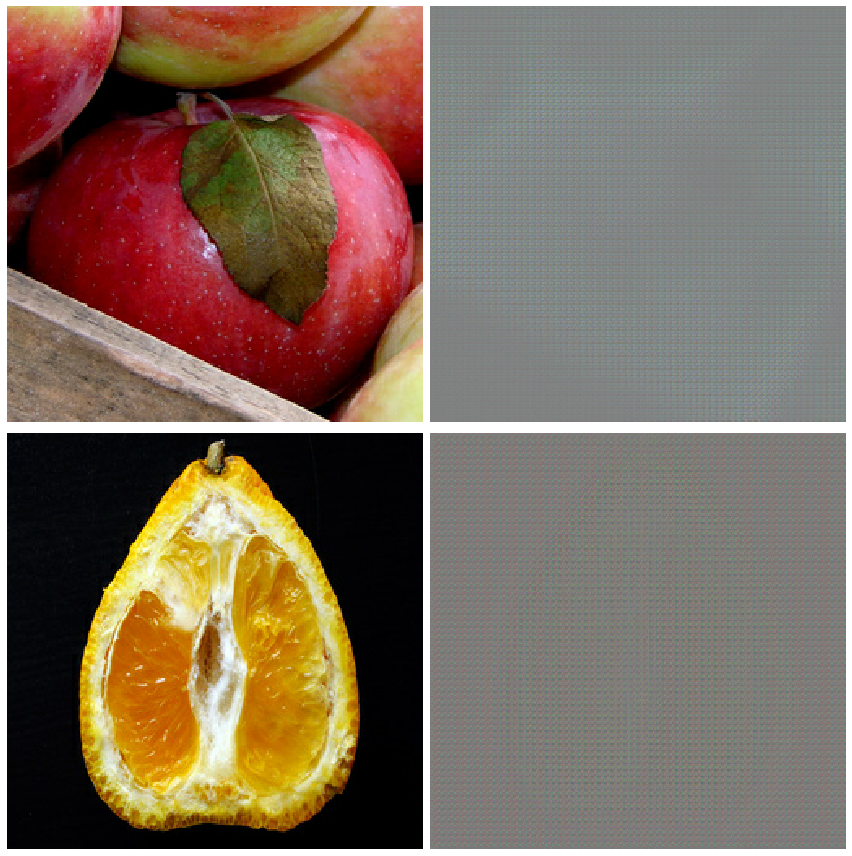

In [22]:
    # Sample images
    x = next(iter(test_monet.shuffle(1000))).numpy()
    y = next(iter(test_photo.shuffle(1000))).numpy()
    
    # Get predictions for those images
    y_hat = generator_g.predict(x.reshape((1, IMG_SIZE, IMG_SIZE, 3)))
    x_hat = generator_f.predict(y.reshape((1, IMG_SIZE, IMG_SIZE, 3)))
    
    plt.figure(figsize=(12, 12))

    images = [x[0], y_hat[0], y[0], x_hat[0]]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
import time
epochs=10
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    start = time.time()

    # Each batch
    for k, (real_x, real_y) in enumerate(tf.data.Dataset.zip((train_monet, test_photo))):
        if k % 100 == 0: print(k)
        # Train step
        step(tf.reshape(real_x, (1, IMG_SIZE, IMG_SIZE, 3)), tf.reshape(real_y, (1, IMG_SIZE, IMG_SIZE, 3)))
    
    # View progress
    generate_images()
    print('Time taken: {}'.format(time.time() - start))

Epoch: 0
0


ResourceExhaustedError: OOM when allocating tensor with shape[1,256,66,66] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]